Predicting how each node will act in the round - this will predict how the overall structure will evolve over time

## Imports

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

## Define model

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


## Train model

In [6]:
df = pd.read_csv('../data/agent_simulation.csv')

# Use the last round only (for simplicity)
latest_round = df['round'].max()
df_latest = df[df['round'] == latest_round]
# df_latest = df

# Build graph
G = nx.watts_strogatz_graph(n=50, k=6, p=0.3)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()

# Node features: degree + current strategy
features = torch.tensor(df_latest[['degree', 'current_strategy']].values, dtype=torch.float)

# Labels: next strategy (cooperate/defect)
labels = torch.tensor(df_latest['label'].values, dtype=torch.long)

# PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index, y=labels)

# Model + optimizer
model = GCN(input_dim=2, hidden_dim=16, output_dim=2)  # Binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        acc = (pred == data.y).sum().item() / data.num_nodes
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")


Epoch 0, Loss: 2.1679, Accuracy: 0.0000
Epoch 10, Loss: 0.0503, Accuracy: 1.0000
Epoch 20, Loss: 0.0048, Accuracy: 1.0000
Epoch 30, Loss: 0.0017, Accuracy: 1.0000
Epoch 40, Loss: 0.0011, Accuracy: 1.0000
Epoch 50, Loss: 0.0009, Accuracy: 1.0000
Epoch 60, Loss: 0.0008, Accuracy: 1.0000
Epoch 70, Loss: 0.0008, Accuracy: 1.0000
Epoch 80, Loss: 0.0008, Accuracy: 1.0000
Epoch 90, Loss: 0.0007, Accuracy: 1.0000


## Evaluate model

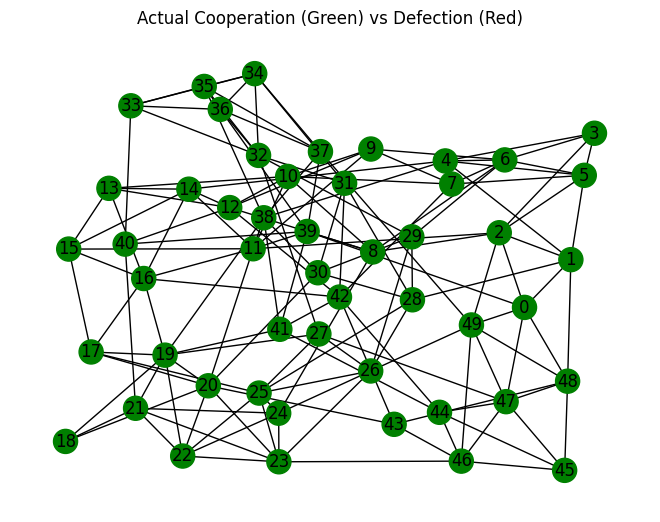

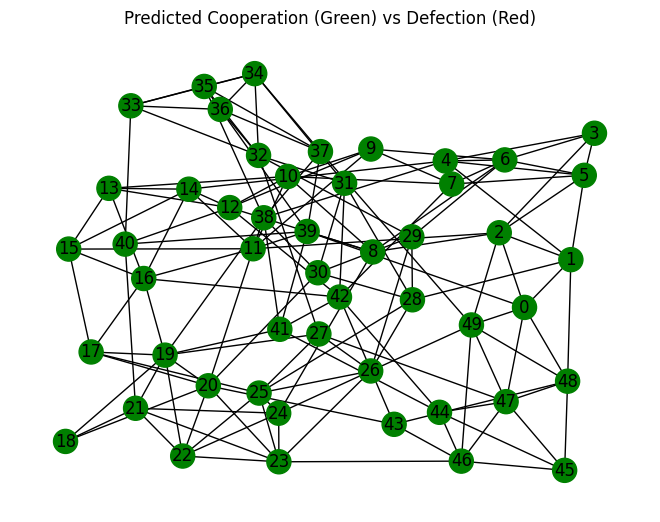

In [ ]:

# Evaluate on the same data (since we're just demoing)
model.eval()
out = model(data.x, data.edge_index)
pred = out.argmax(dim=1)

# # Visualize graph predictions
G_nx = nx.watts_strogatz_graph(n=50, k=6, p=0.3)
pos = nx.spring_layout(G_nx)

def plot_graph(predictions, title):
    color_map = ['green' if p == 1 else 'red' for p in predictions]
    nx.draw(G_nx, pos, node_color=color_map, with_labels=True)
    plt.title(title)
    plt.show()

# Actual labels
plot_graph(data.y.tolist(), title="Actual Cooperation (Green) vs Defection (Red)")

# Predicted labels
plot_graph(pred.tolist(), title="Predicted Cooperation (Green) vs Defection (Red)")
